<a href="https://colab.research.google.com/github/hamzi27/adv-ml-assignment1/blob/master/ass1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amrani Hamza - 807386

## Load data

In [1]:
import pandas as pd
import numpy as np

url_train = 'https://raw.githubusercontent.com/hamzi27/adv-ml-assignment1/master/train.csv'
url_test = 'https://raw.githubusercontent.com/hamzi27/adv-ml-assignment1/master/test.csv'

train = pd.read_csv(url_train)
test = pd.read_csv(url_test)

print(train.head())
print("Training set data shape: ", train.shape)

   LIMIT_BAL  SEX  EDUCATION  ...  PAY_AMT5  PAY_AMT6  default.payment.next.month
0    20000.0    2          2  ...       0.0       0.0                           1
1   120000.0    2          2  ...       0.0    2000.0                           1
2    90000.0    2          2  ...    1000.0    5000.0                           0
3    50000.0    2          2  ...    1069.0    1000.0                           0
4    50000.0    1          2  ...     689.0     679.0                           0

[5 rows x 24 columns]
Training set data shape:  (27000, 24)


# Analysis on data

In [0]:
# !pip install -U pandas_profiling

In [0]:
#import pandas_profiling

# train.profile_report(style={'full_width':True})


# Removing columns highly correlated and duplicates rows

In [2]:
# Drop of duplicates rows
train = train.drop_duplicates()
test = test.drop_duplicates()

# Drop columns lowly correlated to target

train.drop(columns=['AGE','EDUCATION','LIMIT_BAL','MARRIAGE','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4',
                    'PAY_AMT5','PAY_AMT6','SEX','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6'], axis=1, inplace=True)
test.drop(columns=['AGE','EDUCATION','LIMIT_BAL','MARRIAGE','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4',
                    'PAY_AMT5','PAY_AMT6','SEX','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6'], axis=1, inplace=True)

print("Train shape: ", train.shape)
print("Number of 0: ", sum(train['default.payment.next.month']==0))
print("Number of 1: ", sum(train['default.payment.next.month']==1))

Train shape:  (26973, 7)
Number of 0:  21004
Number of 1:  5969


# Split train

In [3]:
from sklearn.model_selection import train_test_split

train, validation = train_test_split( train,test_size=0.2)

print("Train: ", train.shape)

num_0 = sum(train['default.payment.next.month']==0)
num_1 = sum(train['default.payment.next.month']==1)
print("Number of 0: ", num_0)
print("Number of 1: ", num_1)

print("\nValidation: ", validation.shape)
print("Number of 0: ", sum(validation['default.payment.next.month']==0))
print("Number of 1: ", sum(validation['default.payment.next.month']==1))

Train:  (21578, 7)
Number of 0:  16813
Number of 1:  4765

Validation:  (5395, 7)
Number of 0:  4191
Number of 1:  1204


# Over-sample data

In [4]:
from numpy.random import random_sample

train_1 = train[train['default.payment.next.month']==1]

values = [train_1[column].value_counts(normalize=True).keys().tolist() for column in train_1.columns[:-1]]
probabilities = [train_1[column].value_counts(normalize=True).tolist() for column in train_1.columns[:-1]]

verify = {}
for index, row in train_1.iterrows():
    verify [str(row.values)]=1
    
sample_rows = []
for _ in range(num_0-num_1):
  while True:
    sample_row = []
    
    for i in range(len(values)):
      bins = np.add.accumulate(probabilities[i])
      sample_of_column = [values[i][n] for n in np.digitize(random_sample(1), bins)]
      sample_row.extend(sample_of_column)
    sample_row.extend([1])
    
    try:
      verify[str(sample_row)]
    except:
      verify[str(sample_row)] = 1
      break
  
  sample_rows.append(sample_row)

train_oversample = pd.DataFrame(sample_rows, columns = train.columns) 
train = train.append(train_oversample, ignore_index=True)

print(train.head())

print("Ended over-sample on train!")
print("Number of 0: ", sum(train['default.payment.next.month']==0))
print("Number of 1: ", sum(train['default.payment.next.month']==1))



   PAY_0  PAY_2  PAY_3  PAY_4  PAY_5  PAY_6  default.payment.next.month
0      0      0      0      0      0      0                           0
1     -1     -1     -1     -1      0      0                           0
2      0      0      0      0      0      0                           0
3     -2     -2     -2     -1     -1     -1                           0
4     -2     -2     -2     -2     -2     -2                           0
Ended over-sample on train!
Number of 0:  16813
Number of 1:  16813


# Standardization

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

def load_data(df, train=True):
    X = df.values.copy()
    if train:
        np.random.shuffle(X)  
        X, labels = X[:, 0:-1].astype(np.float32), X[:, -1]
        return X, labels
    else:
        X, ids = X[:, 0:].astype(np.float32), X[:, 0].astype(str)
        return X, ids


def preprocess_labels(labels, encoder=None, categorical=True):
    """Encode labels with values among 0 and `n-classes-1`"""
    if not encoder:
        encoder = LabelEncoder()
        encoder.fit(labels)
    y = encoder.transform(labels).astype(np.int32)
    if categorical:
        y = np_utils.to_categorical(y)
    return y, encoder
  

X_train, Y_train = load_data(train, train=True)
X_val, Y_val = load_data(train, train=True)
X_test, Y_test = load_data(test, train=False)
  
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


Y_train, encoder = preprocess_labels(Y_train)
Y_val, encoder_val = preprocess_labels(Y_val)

nb_classes = Y_train.shape[1]
dims = X_train.shape[1]

print(nb_classes, 'classes')
print(dims, 'dims')

Using TensorFlow backend.


2 classes
6 dims


# Neural Network

In [6]:
pip install keras_metrics

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.core import Activation, Dropout
import keras_metrics

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(dims,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
          
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics =["accuracy", keras_metrics.binary_precision(), keras_metrics.binary_recall(), keras_metrics.binary_f1_score()])

model.summary()






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                448       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 2,594
Trainable params: 2,594
Non-trainable params: 0
_________________________________________________________________


In [8]:
hist = model.fit(X_train, Y_train, validation_split=0.2, epochs=100, batch_size=128, verbose=True) 




Train on 26900 samples, validate on 6726 samples





Epoch 1/100
26900/26900 [==============================] - 1s 36us/step - loss: 0.5798 - acc: 0.7651 - precision: 0.7358 - recall: 0.8246 - f1_score: 0.7777 - val_loss: 0.5117 - val_acc: 0.8043 - val_precision: 0.8032 - val_recall: 0.8131 - val_f1_score: 0.8082
Epoch 2/100
26900/26900 [==============================] - 0s 15us/step - loss: 0.4825 - acc: 0.8089 - precision: 0.8090 - recall: 0.8071 - f1_score: 0.8081 - val_loss: 0.4610 - val_acc: 0.8147 - val_precision: 0.8231 - val_recall: 0.8082 - val_f1_score: 0.8156
Epoch 3/100
26900/26900 [==============================] - 0s 16us/step - loss: 0.4453 - acc: 0.8143 - precision: 0.8202 - recall: 0.8036 - f1_score: 0.8118 - val_loss: 0.4316 - val_acc: 0.8174 - val_precision: 0.8290 - val_recall: 0.8061 - val_f1_score: 0.8174
Epoch 4/100
26900/26900 [==============================] - 0s 15us/step - loss: 0.4223 - acc: 0.8185 - precision: 0.8275 - recall: 0.8031 - f1_score: 0.8151 -

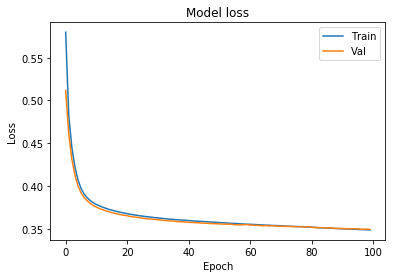

In [9]:
# Plot model loss

import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

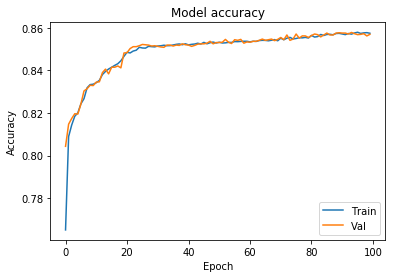

In [10]:
# Plot model acuracy

import matplotlib.pyplot as plt

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [11]:
results = model.evaluate(X_val, Y_val)

print('test loss, test acc:', results)

33626/33626 [==============================] - 1s 23us/step
test loss, test acc: [0.34816408387960784, 0.8575507048188431, 0.8313033893588795, 0.8971629096479083, 0.8629783813280267]


In [12]:
from sklearn.metrics import classification_report, confusion_matrix

Y_val_true = [ enc[int(max(enc))] for enc in Y_val]

print( 'Classification report\n', classification_report(Y_val_true, model.predict_classes(X_val)) )

Classification report
               precision    recall  f1-score   support

         0.0       0.83      0.90      0.86     16813
         1.0       0.89      0.82      0.85     16813

    accuracy                           0.86     33626
   macro avg       0.86      0.86      0.86     33626
weighted avg       0.86      0.86      0.86     33626




Normalized confusion matrix


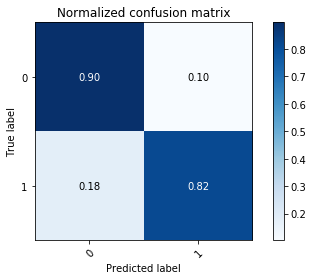

In [13]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("\nNormalized confusion matrix")
    else:
        print('\nConfusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

  
plot_confusion_matrix(Y_val_true, model.predict_classes(X_val), ['0','1'], normalize = True)


In [14]:
# Predict on test

print(X_test)

Y_test_pred = model.predict_classes(X_test)
print(Y_test_pred)

[[ 0.5072648  -1.3898492  -1.3375895  -1.2943534  -1.2877427  -0.6094199 ]
 [-0.18169579 -0.07260772 -0.04810729 -0.01735526  0.01030688  0.03708776]
 [-0.18169579 -0.07260772 -0.04810729 -0.01735526  0.01030688  0.03708776]
 ...
 [ 1.1962254  -0.07260772 -0.04810729 -0.01735526  0.01030688  1.330103  ]
 [-1.5596169  -1.3898492  -1.3375895  -1.2943534  -1.2877427  -1.2559274 ]
 [-0.8706563  -0.7312285  -0.69284844 -0.6558543  -0.6387179  -0.6094199 ]]
[0 0 0 ... 1 0 0]
